$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\var}{var}
    \DeclareMathOperator{\cov}{cov}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \DeclareMathOperator{\GP}{\mathcal{GP}}
    \newcommand{\Tn}{\mathrm{T}_{n}}
    \newcommand{\Tx}{\mathrm{T}_{x}}
    \newcommand{\station}[1]{\mathrm{station}\sbr{#1}}
    \newcommand{\xvec}{\mathbf{x}}
    \newcommand{\indep}{\perp}
    \newcommand{\iid}{iid}
    \newcommand{\trans}{^{\intercal}}
    \newcommand{\sigmaf}{\sigma_{\mathrm{GP}}}
    \newcommand{\sigman}{\sigma_{\epsilon}}
$$

In this notebook, we implement the `SESE_24` kernel with a periodic kernel to capture the diurnal cycle.

In [1]:
using TimeSeries
using DataFrames
using GaussianProcesses
using GaussianProcesses: Mean, Kernel, evaluate, metric, IsotropicData, VecF64
using GaussianProcesses: Stationary, KernelData, MatF64
import GaussianProcesses: optimize!, get_optim_target, cov, grad_slice!
import GaussianProcesses: num_params, set_params!, get_params, update_mll!, update_mll_and_dmll!
import GaussianProcesses: get_param_names, cov!, addcov!, multcov!
import Proj4
using Optim
using Distances
;

In [2]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(6,4))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

# Data Import and Preprocessing

In [3]:
include("iowa.jl")
iowa = prepare_iowa_data(data_dir);

# Kernel with diurnal component

In [4]:
k_time = SEIso(log(3.0), log(3.0)) # start with 3 hours timescale and 3°C variance
k_spatial = fix(SEIso(log(5e4), log(1.0)), :lσ) # 50km is a typical distance between stations, 
                                                # fix σ to 1.0 (unidentifiable)

k_means = SEIso(log(1.0), log(20.0))

k_periodic = fix(Periodic(log(1.0), log(3.0), log(24.0)), :lp)
k_diurndecay = fix(SEIso(log(5e4), log(1.0)), :lσ)

k_spatiotemporal = Masked(k_time, [1]) * Masked(k_spatial, [2,3]) + 
    fix(Masked(k_means, [2,3])) +
    Masked(k_periodic, [1]) * Masked(k_diurndecay, [2,3])
;

# Optimizing hyperparameters

In [5]:
@time nlopt_out = optim_kernel(k_spatiotemporal, 0.0, 
        iowa[:isdSubset], iowa[:hourly_data], :NLopt; x_tol=1e-10);

1438.400364 seconds (21.76 M allocations: 143.892 GiB, 2.32% gc time)


In [6]:
nlopt_out[:mll]

-54574.07803396979

In [7]:
print(nlopt_out[:hyp])

[-0.823078, 1.03034, 1.14191, 11.9456, -0.395445, 0.837186, 13.8198]

In [8]:
print("\nk: Temporal kernel \n=================\n")
@printf("σ: %5.3f\n", √k_time.σ2)
@printf("l: %5.3f hours\n", √k_time.ℓ2)
print("\nk: Spatial kernel \n=================\n")
# @printf("σ: %5.3f\n", √k_spatial.kern.σ2)
@printf("l: %5.3f km\n", √k_spatial.kern.ℓ2 / 1000)
print("\nk: Periodic kernel \n=================\n")
@printf("σ: %5.3f\n", √k_periodic.kern.σ2)
@printf("l: %5.3f hours\n", √k_periodic.kern.ℓ2)
print("\nk: Periodic decay \n=================\n")
# @printf("σ: %5.3f (constrained to 1)\n", √k_diurndecay.kern.σ2)
@printf("l: %5.3f km\n", √k_diurndecay.kern.ℓ2 / 1000)
print("\n=================\n")
@printf("σy: %5.3f\n", exp(nlopt_out[:hyp][1]))


k: Temporal kernel 
σ: 3.133
l: 2.802 hours

k: Spatial kernel 
l: 154.136 km

k: Periodic kernel 
σ: 2.310
l: 0.673 hours

k: Periodic decay 
l: 1004.277 km

σy: 0.439


# Plotting fitted variogram

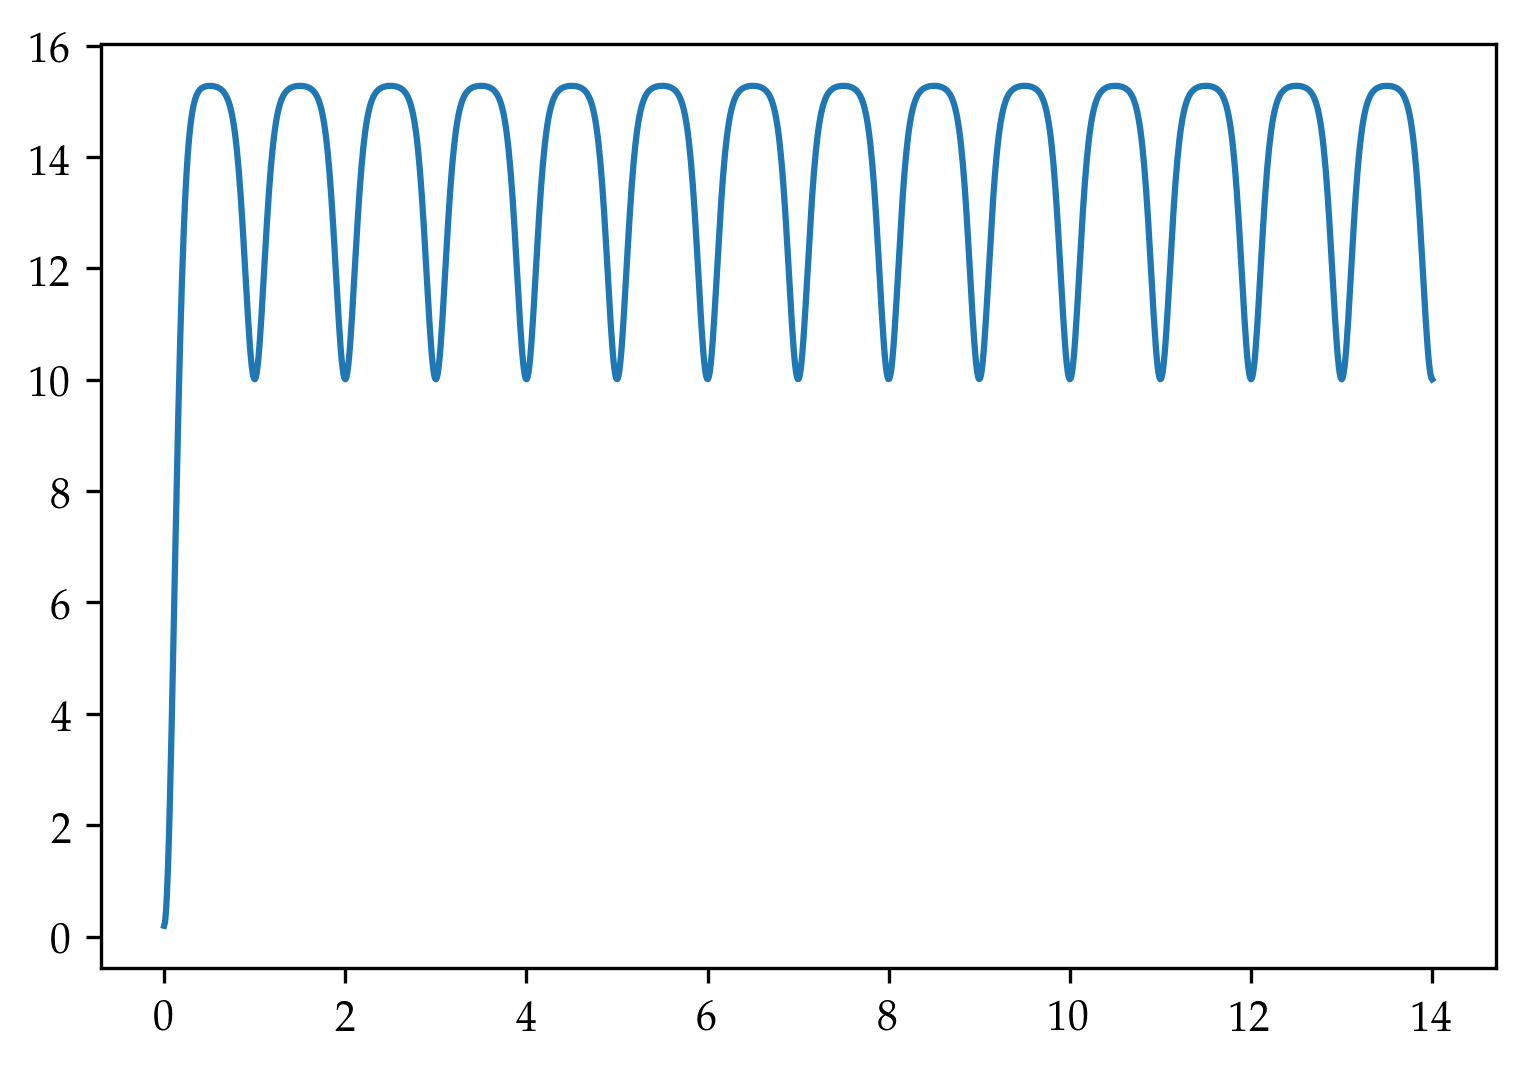

In [11]:
σ2_y = exp(2*nlopt_out[:hyp][1])
rr = linspace(0.0, 24*14, 24*14*4)
ck_r = [cov(k_spatiotemporal, [0.0,0.0,0.0], [r,0.0,0.0]) for r in rr]
plt.plot(rr/24.0, σ2_y + ck_r[1].-ck_r, label="fitted variogram")
;